In [3]:
import numpy as np
import skimage.measure
# import pydicom
import vtk
from vtk.util import numpy_support
import os
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage as ndi

In [ ]:
import gc
gc.collect()

In [20]:
# set working directory
plt.gray()
os.chdir('C:/Users/span/Documents/CNN/')
number1 = 33

<Figure size 432x288 with 0 Axes>

In [21]:
# read dicom _dl_mask
PathDicom = "01_perprocess/"+str(number1)+'/'+str(number1)+"_dl_mask/"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()

# Get the 'vtkImageData' object from the reader
imageData = reader.GetOutput()
# Get the 'vtkPointData' object from the 'vtkImageData' object
pointData = imageData.GetPointData()
# Ensure that only one array exists within the 'vtkPointData' object
assert (pointData.GetNumberOfArrays()==1)
# Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
arrayData = pointData.GetArray(0)

# Convert the `vtkArray` to a NumPy array
ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
# Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')

a_mask = ArrayDicom.copy()

KeyboardInterrupt: 

In [5]:
# output master folder seg3channel
from PIL import Image
from skimage.transform import rescale
from skimage.feature import canny
from skimage import morphology
from scipy import ndimage as ndi

path_master_s3 = "02_data/master_seg3channelfill/"

resize1 = 256

# export master_segre255
for i in range(a_mask.shape[2]):
    image = a_mask[:, :, i].copy()
#     image = ndi.binary_fill_holes(image).astype(np.uint8)
    image1 = (((image - image.min()) / (image.max() - image.min())) * 255.9).astype(np.uint8)
    imagedge = canny(image1, sigma=1)
    imagedge2 = morphology.dilation(imagedge, morphology.disk(radius=1))
    imagedge3 = imagedge2.astype(np.uint8)
    imagedge3 = np.where(imagedge3 != 0, 2, 0)
    image4 = image + imagedge3
    image4 = np.where(image4 > 1, 2, image4)
    img0 = Image.fromarray(image4.astype(np.uint8))
    img0.save(path_master_s3+str(number1)+"_image_"+str("{0:03}".format(i))+".png")

C:\Users\span\anaconda3\envs\tf-n-gpu\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [11]:
# Split to train and val
path_master_i = "02_data/master_image/"
path_master_s3 = "02_data/master_seg3channelfill/"

subfolder1 = "_seg3channel/"
path1 = "02_data/train_image"+subfolder1
path2 = "02_data/train_mask"+subfolder1
path3 = "02_data/val_image"+subfolder1
path4 = "02_data/val_mask"+subfolder1

In [12]:
import random
random.seed(a=1024, version=2)
list1 = os.listdir(path_master_i)
list2 = random.sample(list1, k=round(len(list1)*0.7))
list3 = [x for x in list1 if (x not in list2)]

In [13]:
from shutil import copy

for i in list3:
    copy(path_master_s3+ str(i), path4+'seg/')
    
for i in list2:
    copy(path_master_s3+ str(i), path2+'seg/')

# Add edge for orgi image

In [1]:
from PIL import Image
from skimage.transform import rescale
from skimage.feature import canny
from skimage.filters import threshold_otsu
from skimage import morphology
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

In [4]:
# set working directory
plt.gray()
os.chdir('C:/Users/span/Documents/CNN/')

<Figure size 432x288 with 0 Axes>

In [5]:
def readdicomset(number1):
    # read dicom _dl_input
    PathDicom = "01_perprocess/"+str(number1)+'/'+str(number1)+"_dl_input/"
    # PathDicom = "01_perprocess/"+str(number1)+'/'+str(number1)+"_in/"
    reader = vtk.vtkDICOMImageReader()
    reader.SetDirectoryName(PathDicom)
    reader.Update()
    # Load dimensions using `GetDataExtent`
    _extent = reader.GetDataExtent()
    ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]
    # Load spacing values
    ConstPixelSpacing = reader.GetPixelSpacing()
    # Get the 'vtkImageData' object from the reader
    imageData = reader.GetOutput()
    # Get the 'vtkPointData' object from the 'vtkImageData' object
    pointData = imageData.GetPointData()
    # Ensure that only one array exists within the 'vtkPointData' object
    assert (pointData.GetNumberOfArrays()==1)
    # Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
    arrayData = pointData.GetArray(0)
    # Convert the `vtkArray` to a NumPy array
    ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
    # Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
    ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')
    return ArrayDicom

In [6]:
def readdicomset2(number1):
    # read dicom _dl_input
    PathDicom = "01_perprocess/"+str(number1)+'/'+str(number1)+"_dl_mask/"
    # PathDicom = "01_perprocess/"+str(number1)+'/'+str(number1)+"_in/"
    reader = vtk.vtkDICOMImageReader()
    reader.SetDirectoryName(PathDicom)
    reader.Update()
    # Load dimensions using `GetDataExtent`
    _extent = reader.GetDataExtent()
    ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]
    # Load spacing values
    ConstPixelSpacing = reader.GetPixelSpacing()
    # Get the 'vtkImageData' object from the reader
    imageData = reader.GetOutput()
    # Get the 'vtkPointData' object from the 'vtkImageData' object
    pointData = imageData.GetPointData()
    # Ensure that only one array exists within the 'vtkPointData' object
    assert (pointData.GetNumberOfArrays()==1)
    # Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
    arrayData = pointData.GetArray(0)
    # Convert the `vtkArray` to a NumPy array
    ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
    # Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
    ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')
    return ArrayDicom

In [40]:
def getorig4(image1,image2):
#     image1
    thresh = threshold_otsu(image1)
    binary = image1 > thresh 
    image11 = (((image1 - image1.min()) / (image1.max() - image1.min())) * 255.9).astype(np.uint8)
    imagedge = canny(image11, sigma=1)
    imagedge2 = morphology.dilation(imagedge, morphology.disk(radius=1))
    imagedge3 = imagedge2.astype(np.uint8)
    imagedge3 = np.where(imagedge3 != 0, 2, 0)
    image4 = binary + imagedge3
    image4 = np.where(image4 > 1, 2, image4)
#     image2
    binary2 = np.where(image2 != 0, 2, 0)
    image12 = (((image2 - image2.min()) / (image2.max() - image2.min())) * 255.9).astype(np.uint8)
    imagedge2 = canny(image12, sigma=1)
    imagedge22 = morphology.dilation(imagedge2, morphology.disk(radius=1))
    imagedge32 = imagedge22.astype(np.uint8)
    imagedge32 = np.where(imagedge32 != 0, 4, 0)
    image42 = binary2 + imagedge32
    image42 = np.where(image42 > 2, 4, image42)
    image5 = image4+image42
    image5 = np.where(image5 >= 5, 4, image5)
    return image5

In [48]:
number1 = 33
a_mask = readdicomset(number1)
a_mask2 = readdicomset2(number1)

In [49]:
path_master_s3 = "06_origdata/master_seg3channelfill/"

resize1 = 256

# export master_segre255
for i in range(a_mask.shape[2]):
    image = getorig4(a_mask[:, :, i], a_mask2[:, :, i])
    image = rescale(image, (resize1/a_mask[:, :, i].shape[1]), preserve_range=True, anti_aliasing=False)
    img0 = Image.fromarray(image.astype(np.uint8))
    img0.save(path_master_s3+str(number1)+"_image_"+str("{0:03}".format(i))+".png")

C:\Users\span\anaconda3\envs\tf-n-gpu\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


IndexError: index 544 is out of bounds for axis 2 with size 544

In [41]:
image6 = getorig4(a_mask[:, :, 150], a_mask2[:, :, 150])

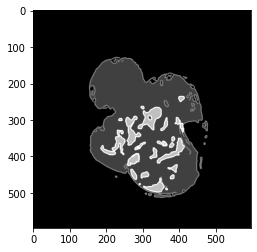

In [42]:
plt.imshow(image6)

In [8]:
image = a_mask[:, :, 150].copy()
#     image = ndi.binary_fill_holes(image).astype(np.uint8)
thresh = threshold_otsu(image)
binary = image > thresh 
image1 = (((image - image.min()) / (image.max() - image.min())) * 255.9).astype(np.uint8)
imagedge = canny(image1, sigma=1)
imagedge2 = morphology.dilation(imagedge, morphology.disk(radius=1))
imagedge3 = imagedge2.astype(np.uint8)
imagedge3 = np.where(imagedge3 != 0, 2, 0)
image4 = binary + imagedge3
image4 = np.where(image4 > 1, 2, image4)

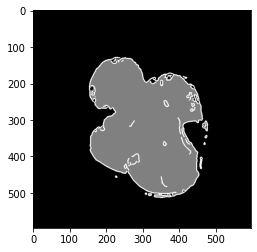

In [9]:
plt.imshow(image4)

In [27]:
image2 = a_mask2[:, :, 150].copy()
#     image = ndi.binary_fill_holes(image).astype(np.uint8)
# thresh2 = threshold_otsu(image2)
binary2 = np.where(image2 != 0, 2, 0)
image12 = (((image2 - image2.min()) / (image2.max() - image2.min())) * 255.9).astype(np.uint8)
imagedge2 = canny(image12, sigma=1)
imagedge22 = morphology.dilation(imagedge2, morphology.disk(radius=1))
imagedge32 = imagedge22.astype(np.uint8)
imagedge32 = np.where(imagedge32 != 0, 4, 0)
image42 = binary2 + imagedge32
image42 = np.where(image42 > 2, 4, image42)

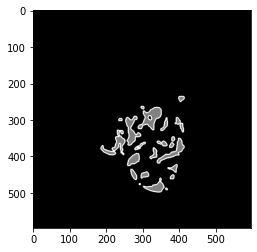

In [28]:
plt.imshow(image42)

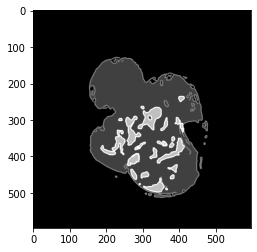

In [34]:
image5 = image4+image42
image5 = np.where(image5 >= 5, 4, image5)
plt.imshow(image5)

In [ ]:
image = a_mask[:, :, 380].copy()
plt.imshow(image)

In [ ]:
# add edge
from skimage.feature import canny

image1 = (((image - image.min()) / (image.max() - image.min())) * 255.9).astype(np.uint8)
imagedge = canny(image1, sigma=1)

In [ ]:
# thicker the edge
from skimage import morphology
imagedge2 = morphology.dilation(imagedge, morphology.disk(radius=1))

In [ ]:
# fill holes
from scipy import ndimage as ndi

fill_coins = ndi.binary_fill_holes(image)
plt.imshow(fill_coins)

In [ ]:
#plot results
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 6.4),
                                    sharex=True, sharey=True)
ax0.imshow(image1, cmap='gray')
ax0.axis('off')
ax0.set_title('org')
ax1.imshow(imagedge, cmap='gray')
ax1.axis('off')
ax1.set_title('edge')
ax2.imshow(imagedge2, cmap='gray') # 'magma'
ax2.axis('edge2')

fig.tight_layout()
plt.show()

In [ ]:
imagedge3 = imagedge2.astype(np.uint8)
imagedge3 = np.where(imagedge3 != 0, 2, 0)
image4 = image + imagedge3
image4 = np.where(image4 > 1, 2, image4)
image5 = image4*255